# For an analysis competition...
- EDA
- feature engineering
- adversarial validation
- feature importance
- one hot nan
- pseudolabel
- data augumentation (mixup...)
- seed averaging
- stacking

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from feature_converter import categorize_features
from categorical_encoder import label_encoding
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/models/') 
from run_models import RunModel
from lgb_param_models import lgb_model
from xgb_param_models import xgb_model
from catb_param_models import catb_model
from lin_param_models import lin_model
from nn_param_models import nn_model

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.

Using TensorFlow backend.


libraries imported


# Load data

In [2]:
!ls

EDA_houseprice.ipynb catboost_info        models
EDA_titanic.ipynb    code
README.md            inputs


In [3]:
# check path
datapath = "inputs/"
files = os.listdir(datapath)
print(files)

['.DS_Store', 'atma2020', 'house-prices-advanced-regression-techniques', 'titanic']


In [4]:
datapath = datapath + 'house-prices-advanced-regression-techniques'
os.listdir(datapath)

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']

In [5]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/train.csv')
test = pd.read_csv(datapath + '/test.csv')
submission = pd.read_csv(datapath + '/sample_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.04899406433105469  seconds to load data


In [6]:
# check train
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# check test
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# Target

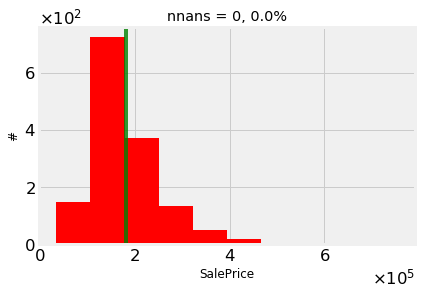

In [10]:
# remove nan from target
target = "SalePrice"
plot_target(train, target, objective="regression")

In [11]:
# roughly categorize features
features, dense_features, cat_features = categorize_features(train, target, cat_threshold=12)

There are 80 features.
There are 23 dense features.
There are 57 categorical features.


# Dense features

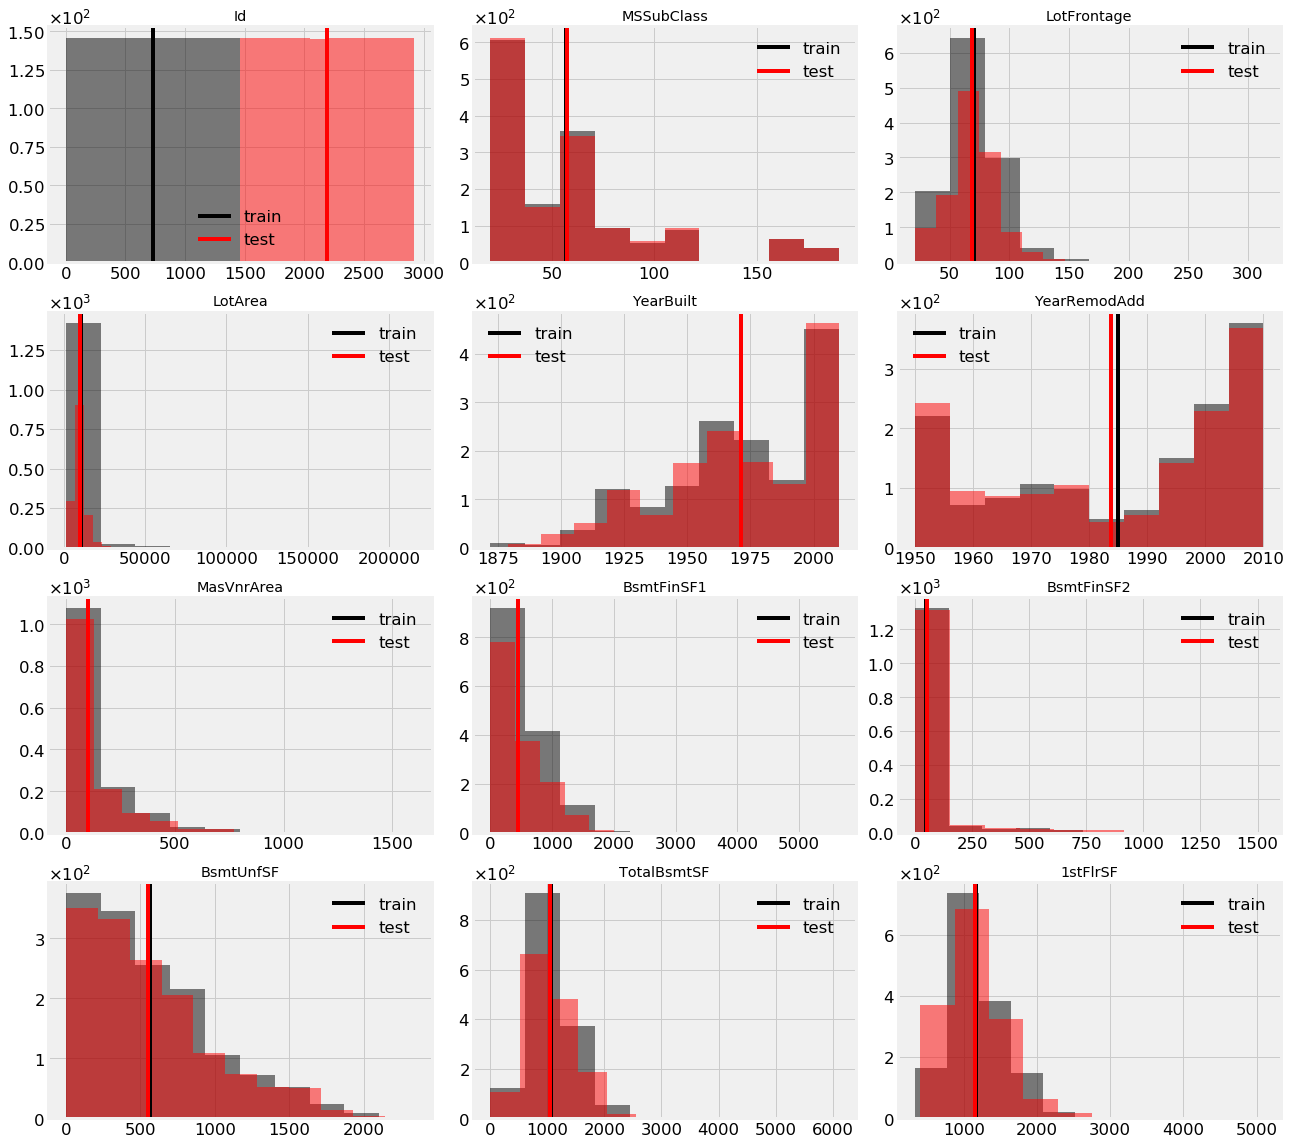

In [12]:
# EDA for dense features
vd = DenseVisualizer(train=train, test=test, features=dense_features[:12], target=target)
vd.plot_bars()

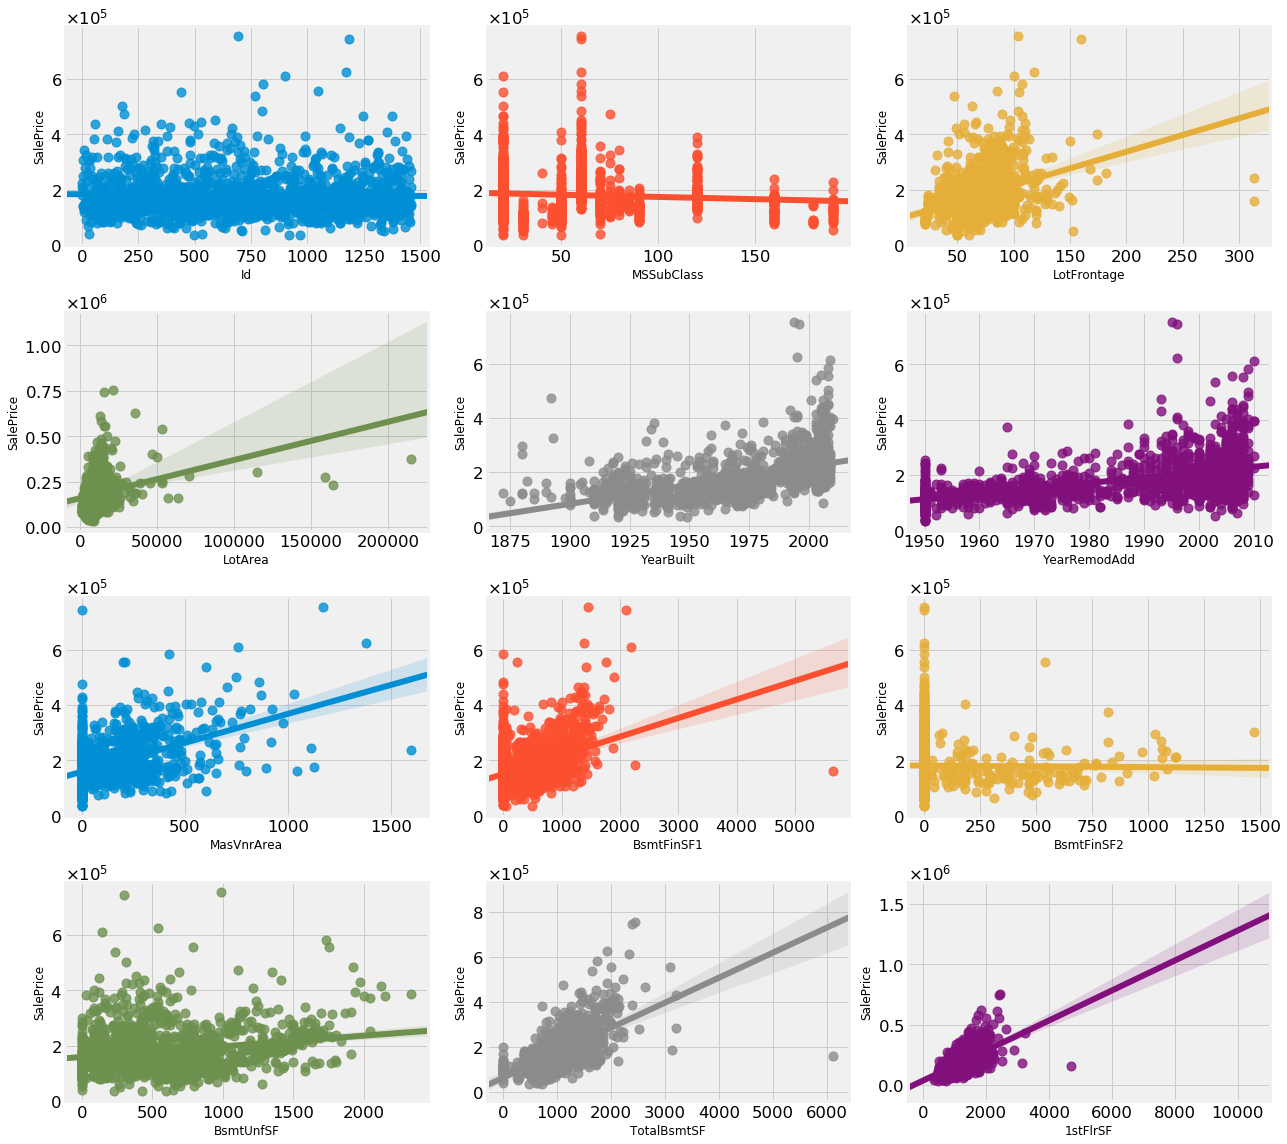

In [13]:
vd.plot_vs_target()

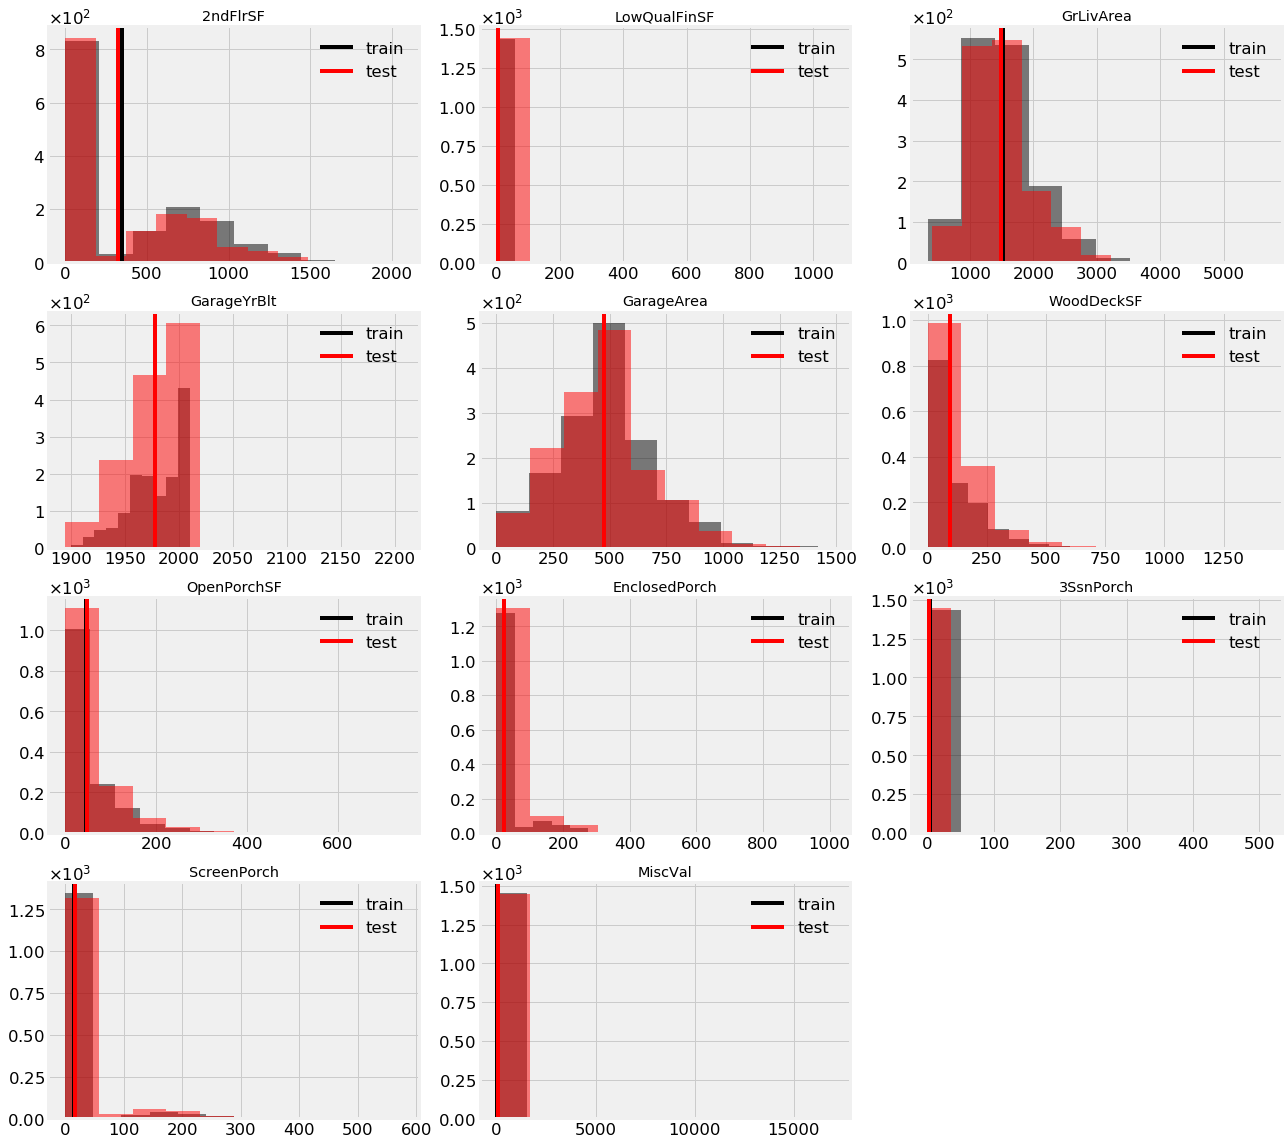

In [14]:
# EDA for dense features
vd = DenseVisualizer(train=train, test=test, features=dense_features[12:24], target=target)
vd.plot_bars()

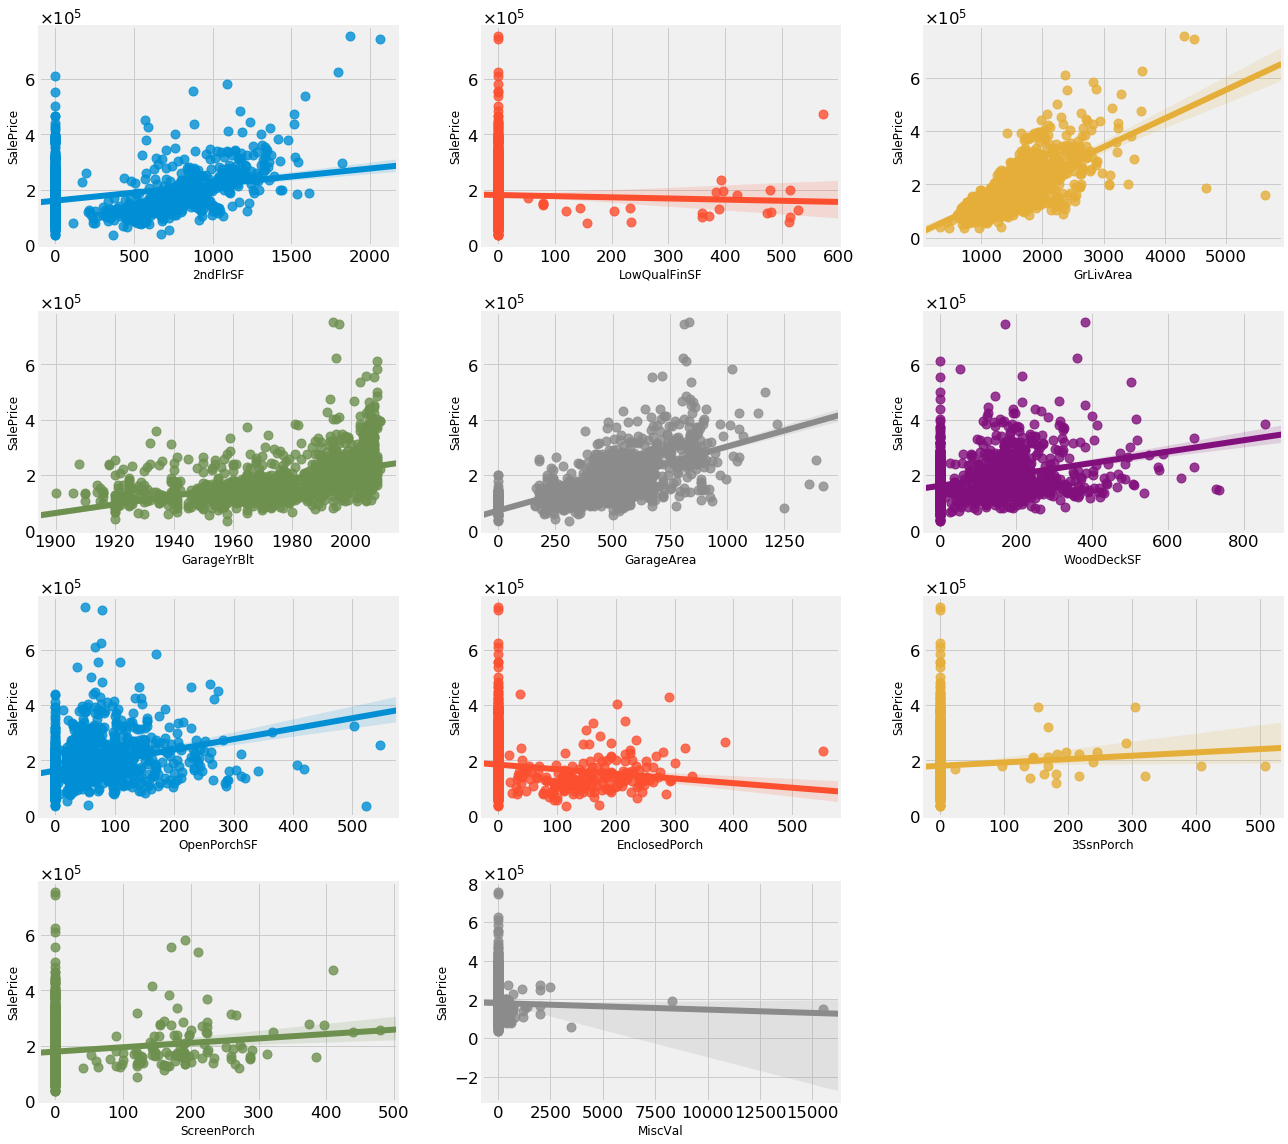

In [15]:
vd.plot_vs_target()

In [16]:
# EDA for dense features
vd = DenseVisualizer(train=train, test=test, features=dense_features[24:37], target=target)
vd.plot_bars()

<Figure size 0x288 with 0 Axes>

In [17]:
vd.plot_vs_target()

<Figure size 0x288 with 0 Axes>

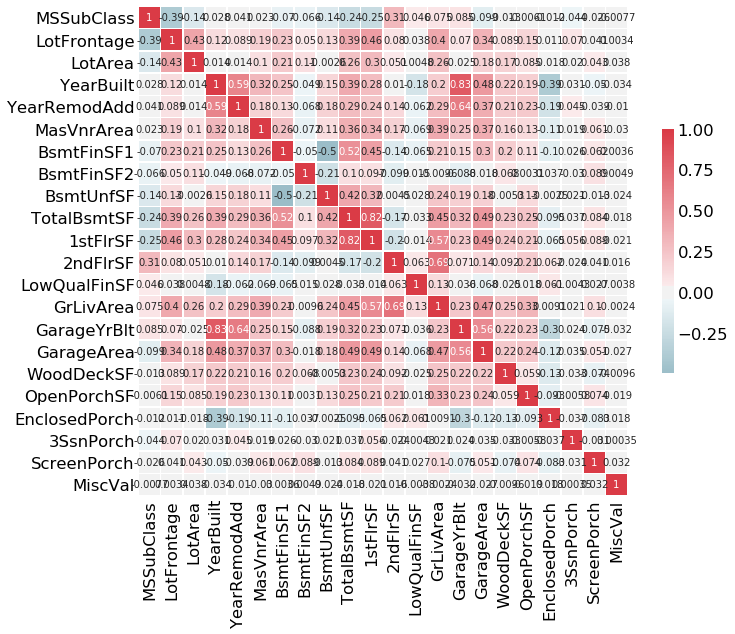

In [18]:
dense_features.remove("Id")
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
vd.correlation_matrix()

In [19]:
chkd = vd.column_checker()

feature name = MSSubClass
feature name = LotFrontage
feature name = LotArea
feature name = YearBuilt
feature name = YearRemodAdd
feature name = MasVnrArea
feature name = BsmtFinSF1
feature name = BsmtFinSF2
feature name = BsmtUnfSF
feature name = TotalBsmtSF
feature name = 1stFlrSF
feature name = 2ndFlrSF
feature name = LowQualFinSF
feature name = GrLivArea
feature name = GarageYrBlt
feature name = GarageArea
feature name = WoodDeckSF
feature name = OpenPorchSF
feature name = EnclosedPorch
feature name = 3SsnPorch
feature name = ScreenPorch
feature name = MiscVal


In [20]:
chkd.style.background_gradient()

,features,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,MSSubClass,0,0,15,16,20,20,190,190,56.8973,57.3783,1.40766,1.34669
1,LotFrontage,259,227,110,115,21,21,313,200,70.05,68.5804,2.16357,0.661921
2,LotArea,0,0,1073,1106,1300,1470,215245,56600,10516.8,9819.16,12.2077,3.11522
3,YearBuilt,0,0,112,106,1872,1879,2010,2010,1971.27,1971.36,-0.613461,-0.587657
4,YearRemodAdd,0,0,61,61,1950,1950,2010,2010,1984.87,1983.66,-0.503562,-0.399906
5,MasVnrArea,8,15,327,303,0,0,1600,1290,103.685,100.709,2.66908,2.53338
6,BsmtFinSF1,0,1,637,669,0,0,5644,4010,443.64,439.204,1.6855,1.16568
7,BsmtFinSF2,0,1,144,161,0,0,1474,1526,46.5493,52.6193,4.25526,4.04134
8,BsmtUnfSF,0,1,780,793,0,0,2336,2140,567.24,554.295,0.920268,0.919916
9,TotalBsmtSF,0,1,721,736,0,0,6110,5095,1057.43,1046.12,1.52425,0.813589


# Categorical features

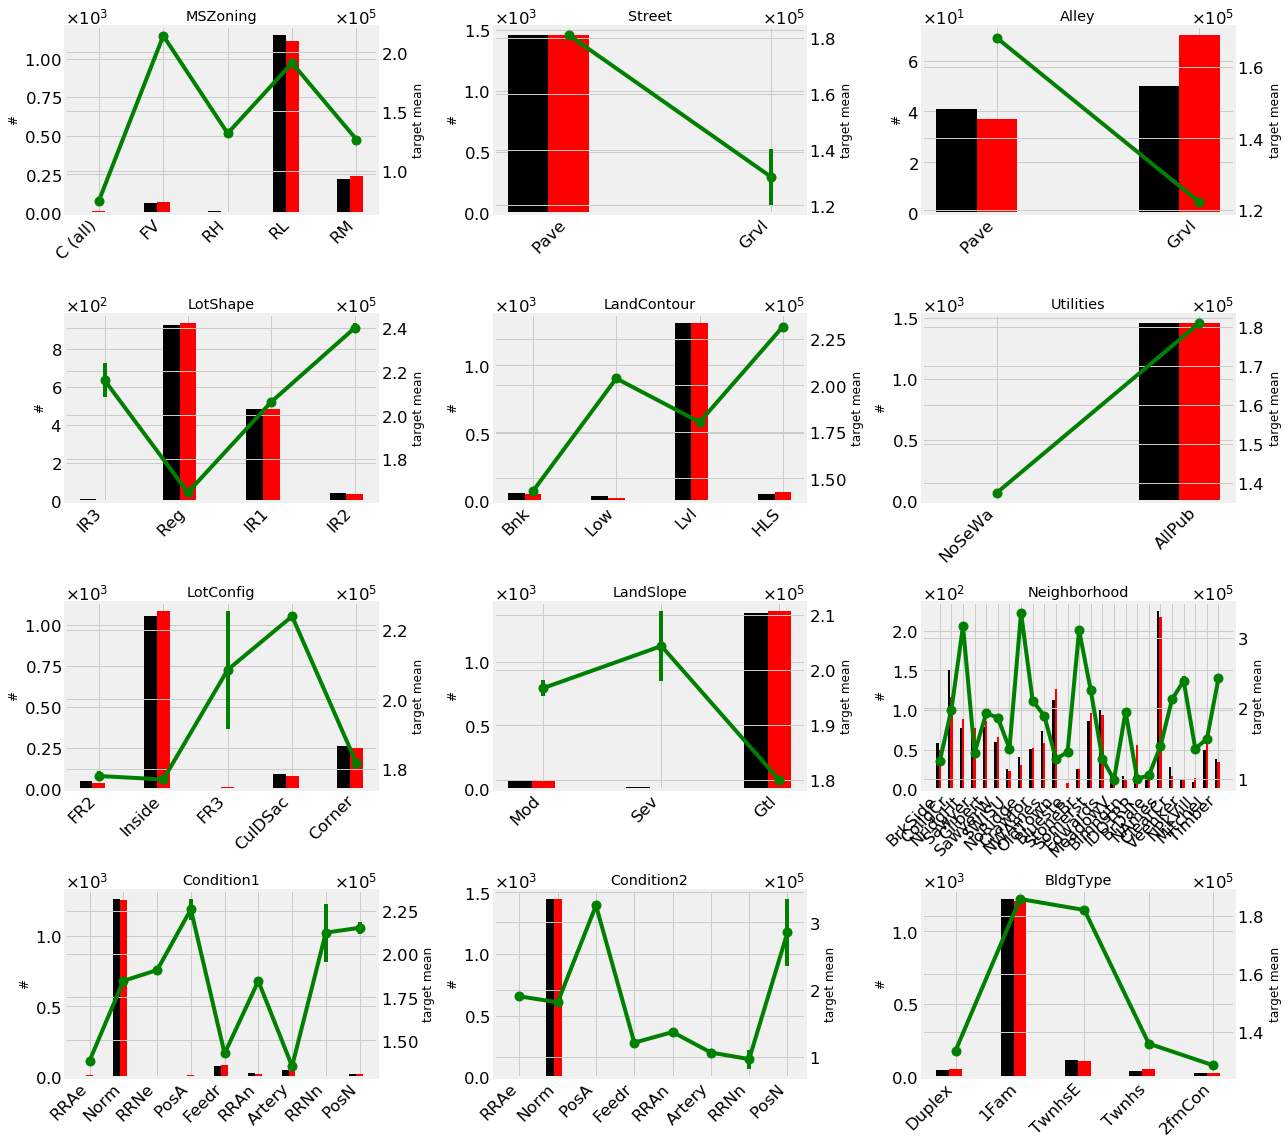

In [21]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features[:12], target=target)
vc.plot_bars()

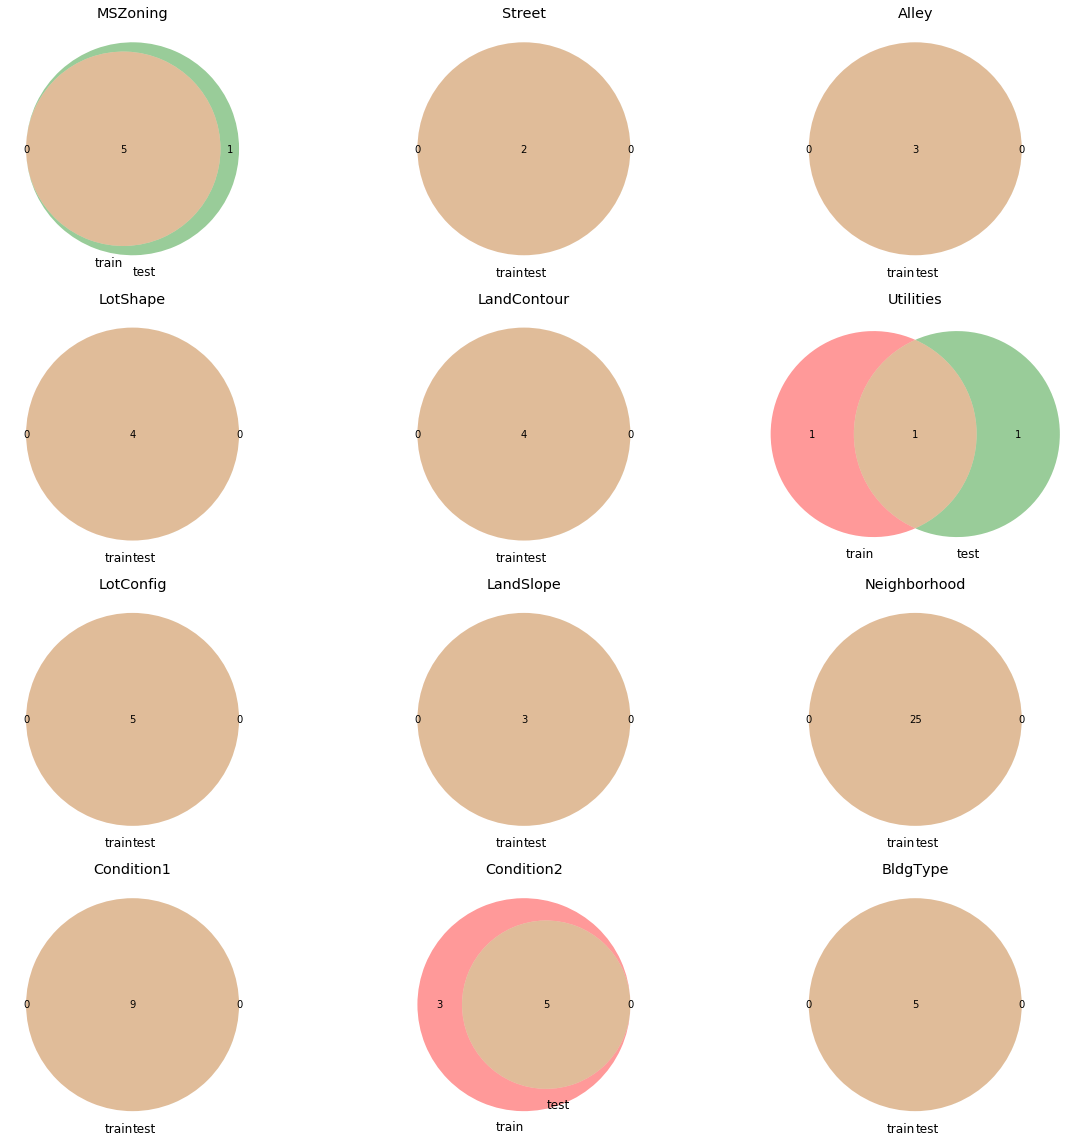

In [22]:
vc.plot_venn()

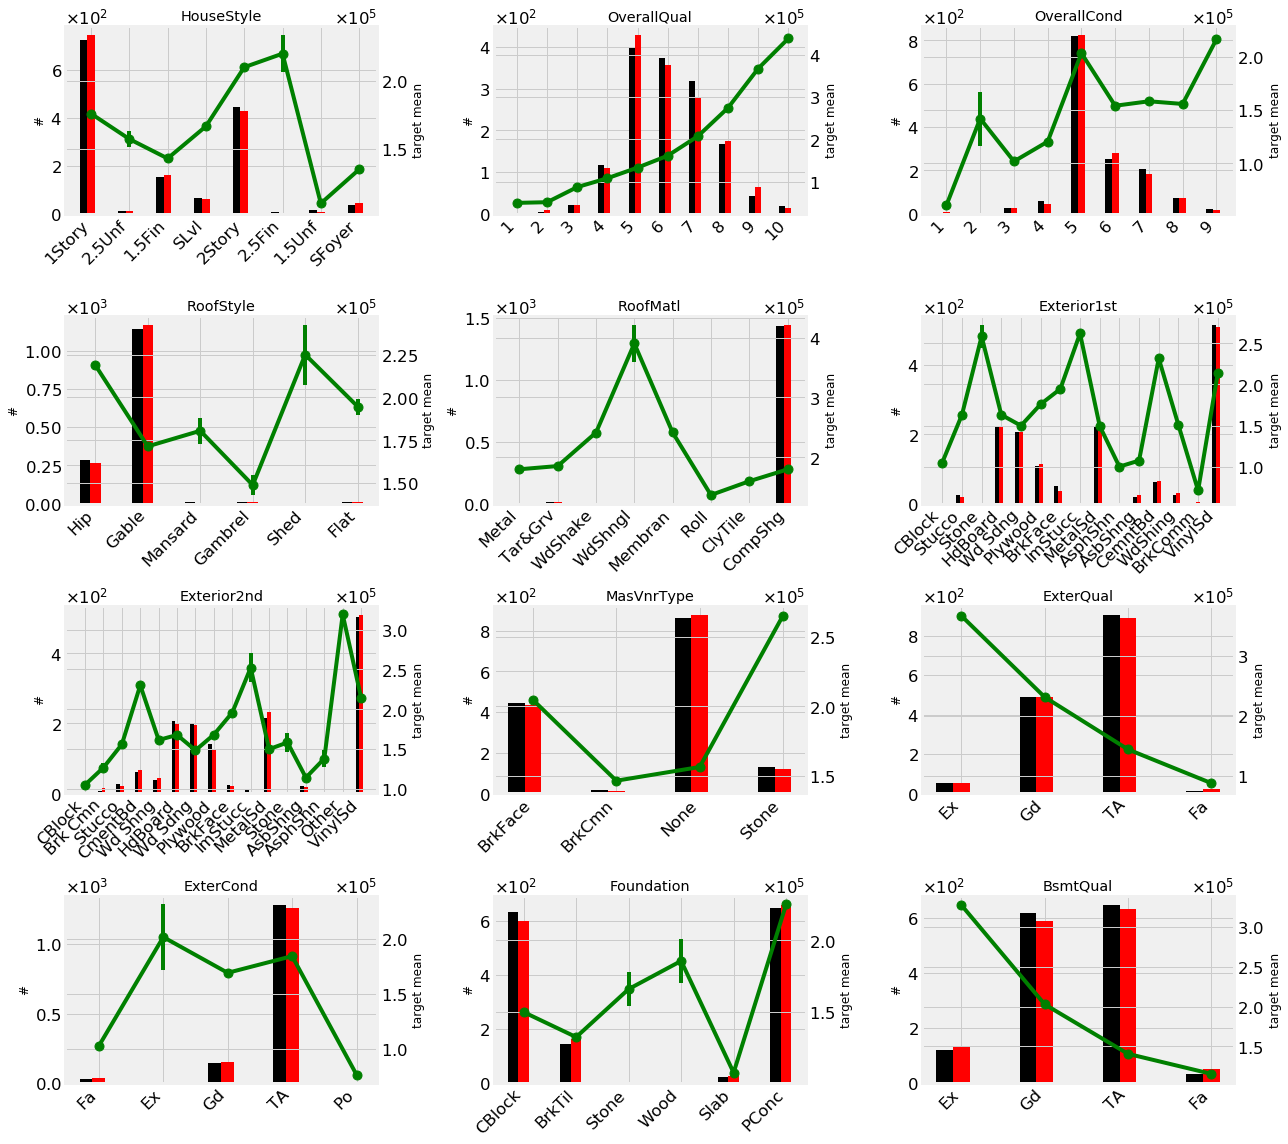

In [23]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features[12:24], target=target)
vc.plot_bars()

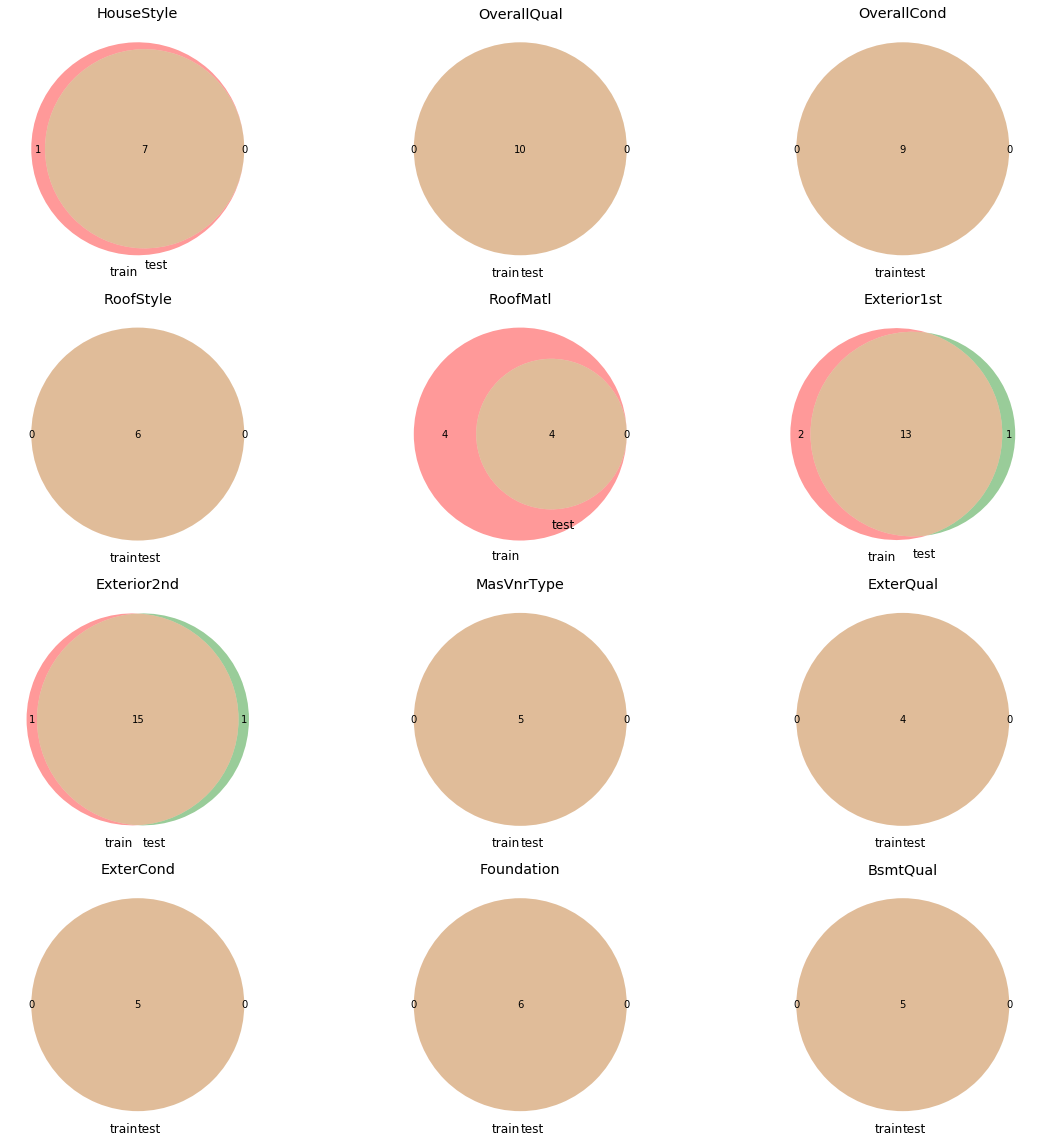

In [24]:
vc.plot_venn()

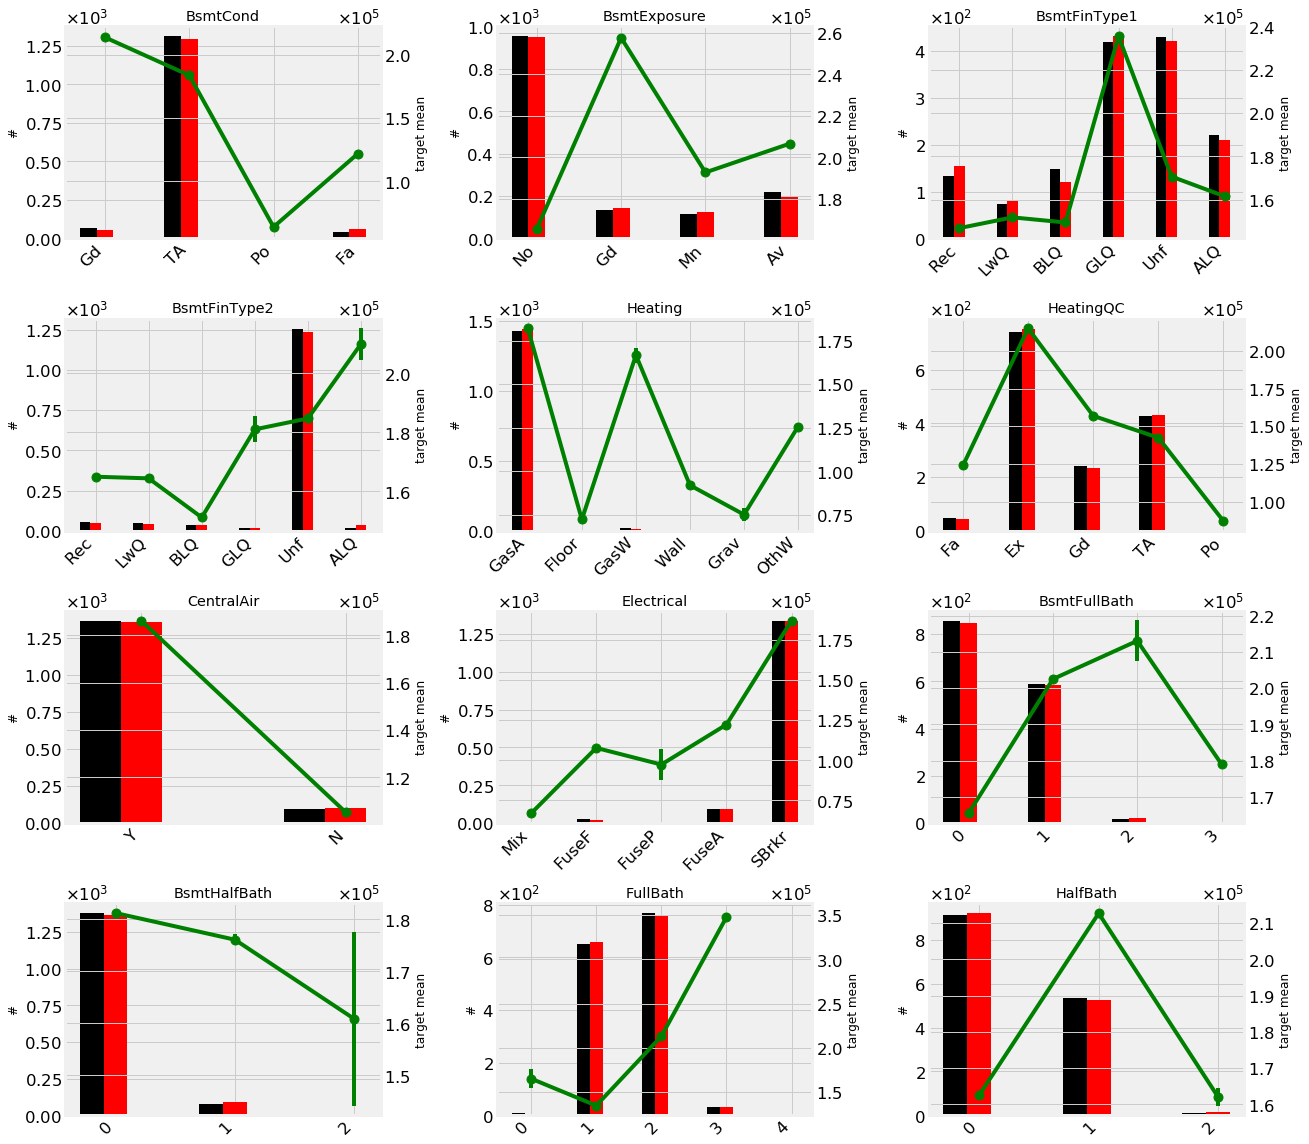

In [25]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features[24:36], target=target)
vc.plot_bars()

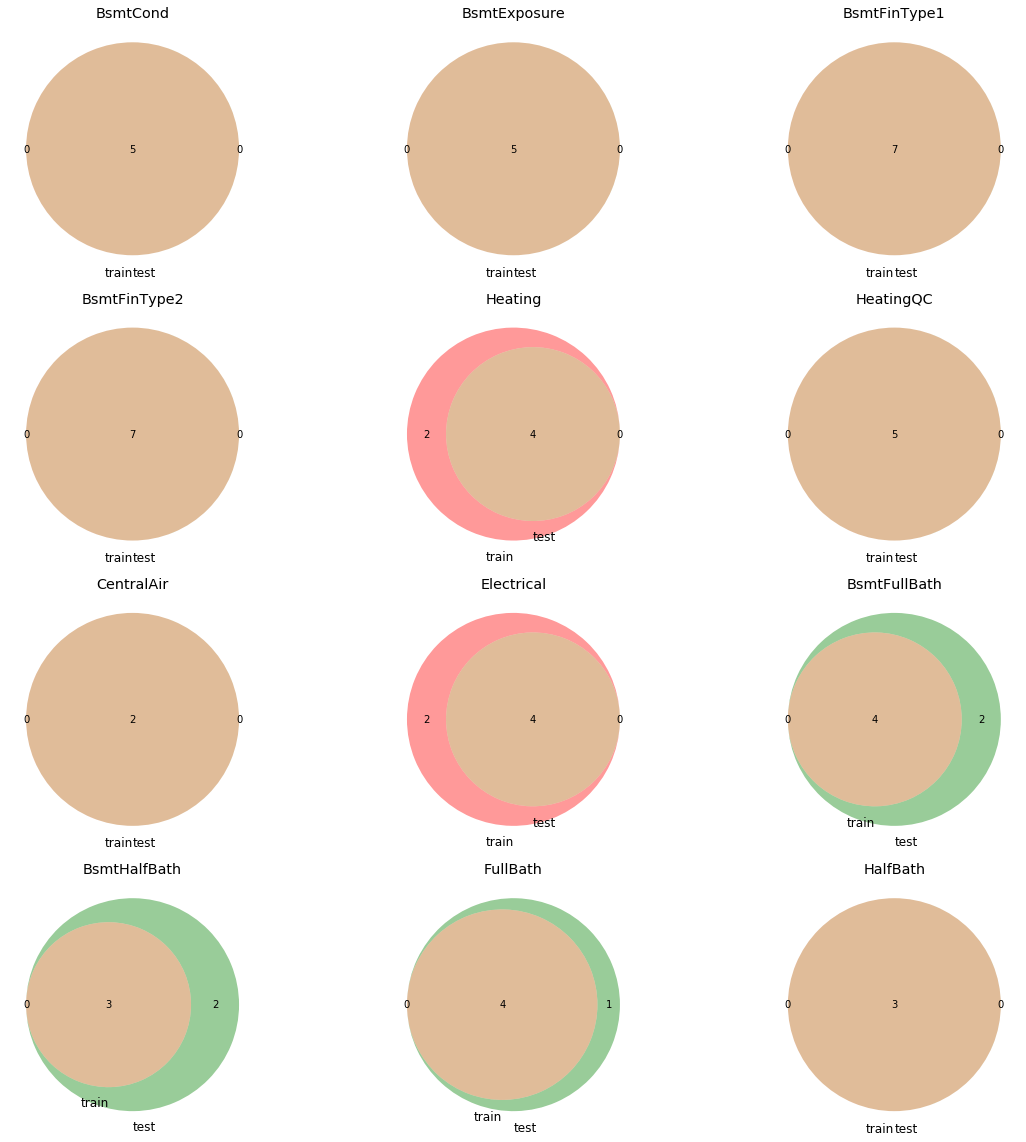

In [26]:
vc.plot_venn()

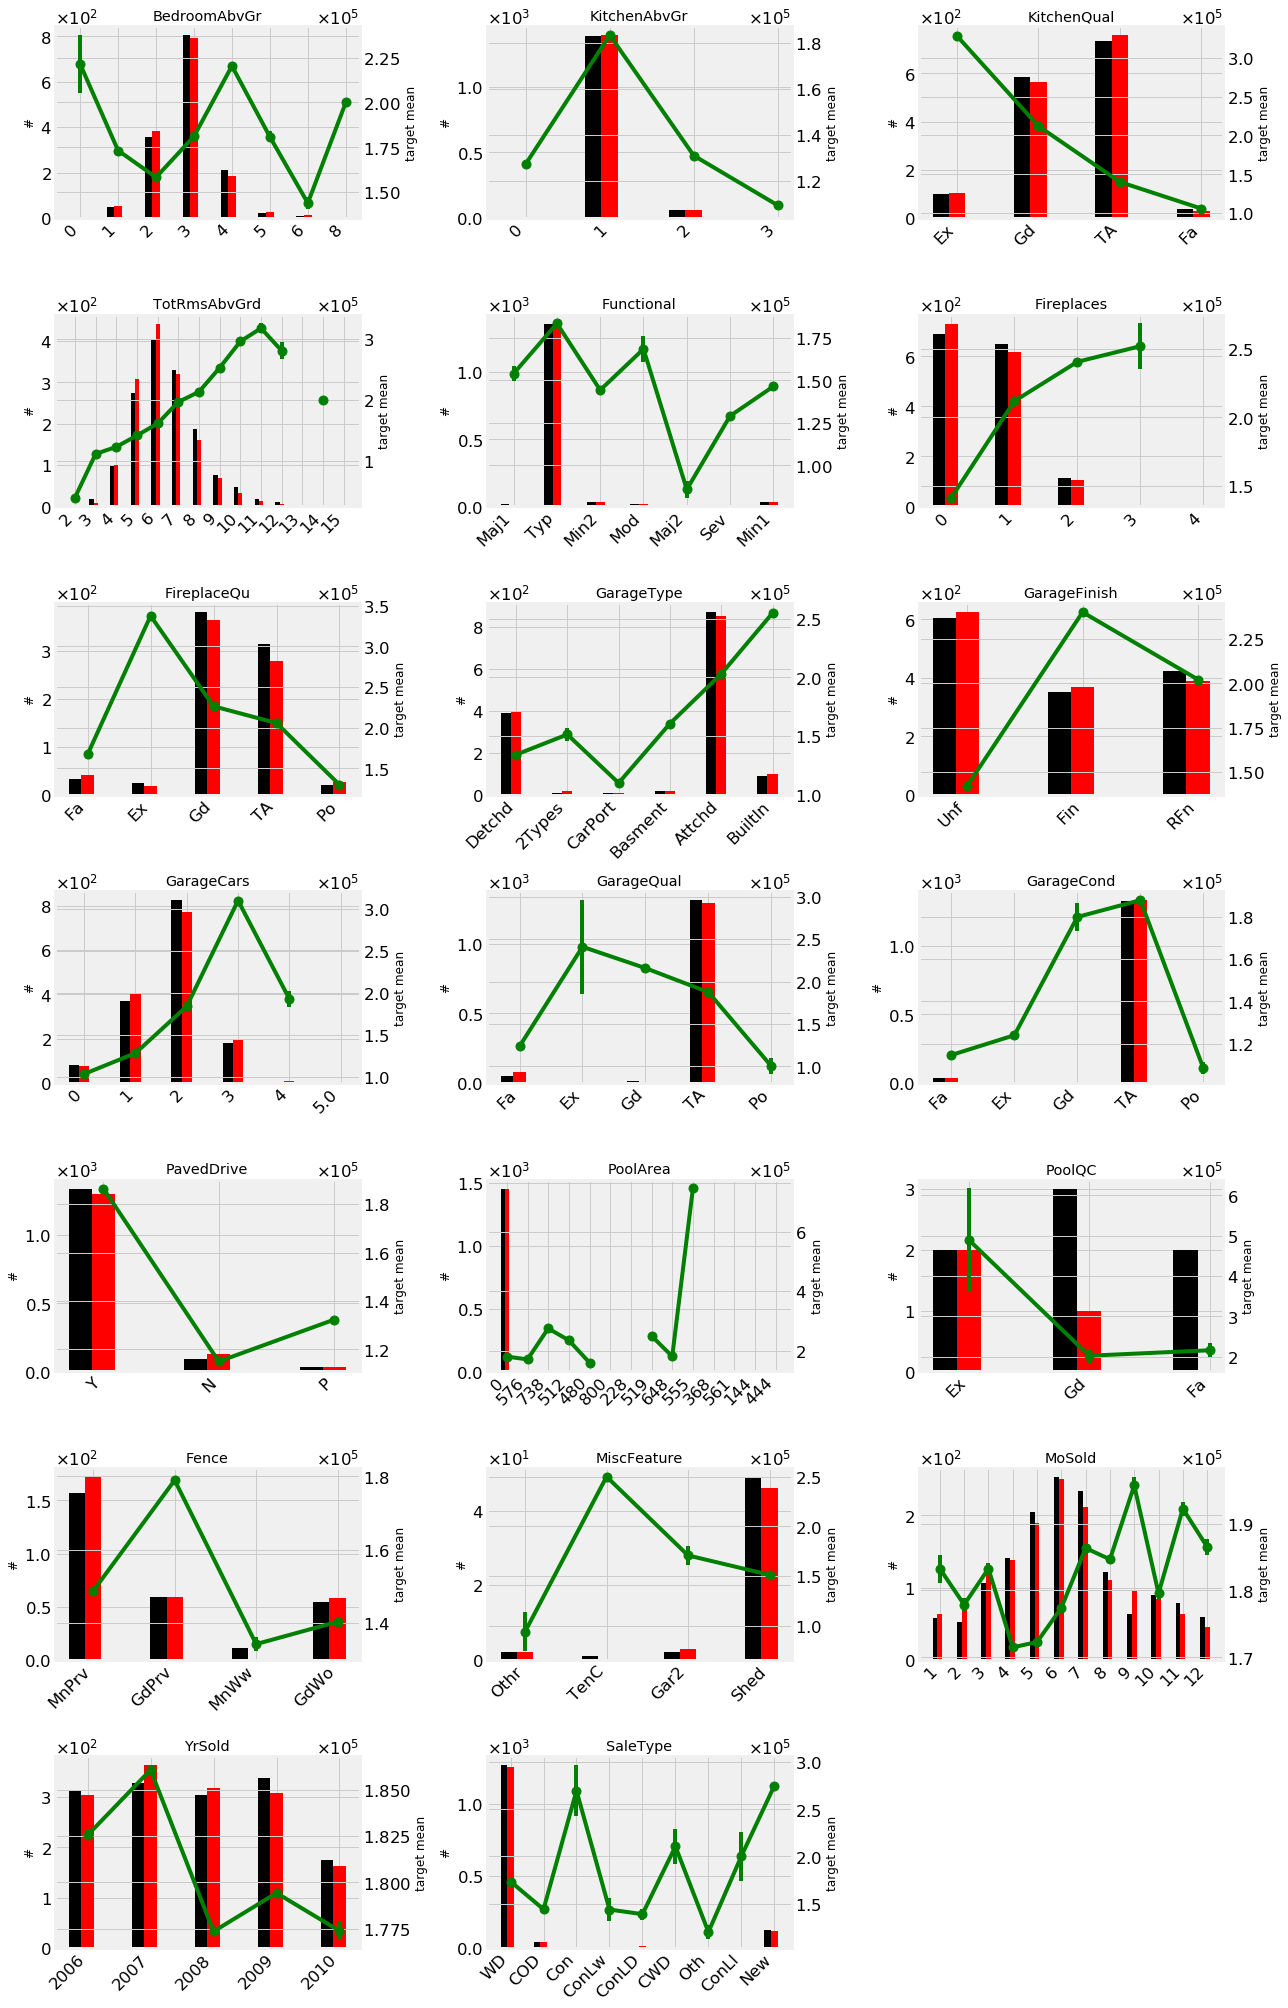

In [27]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features[36:-1], target=target)
vc.plot_bars()

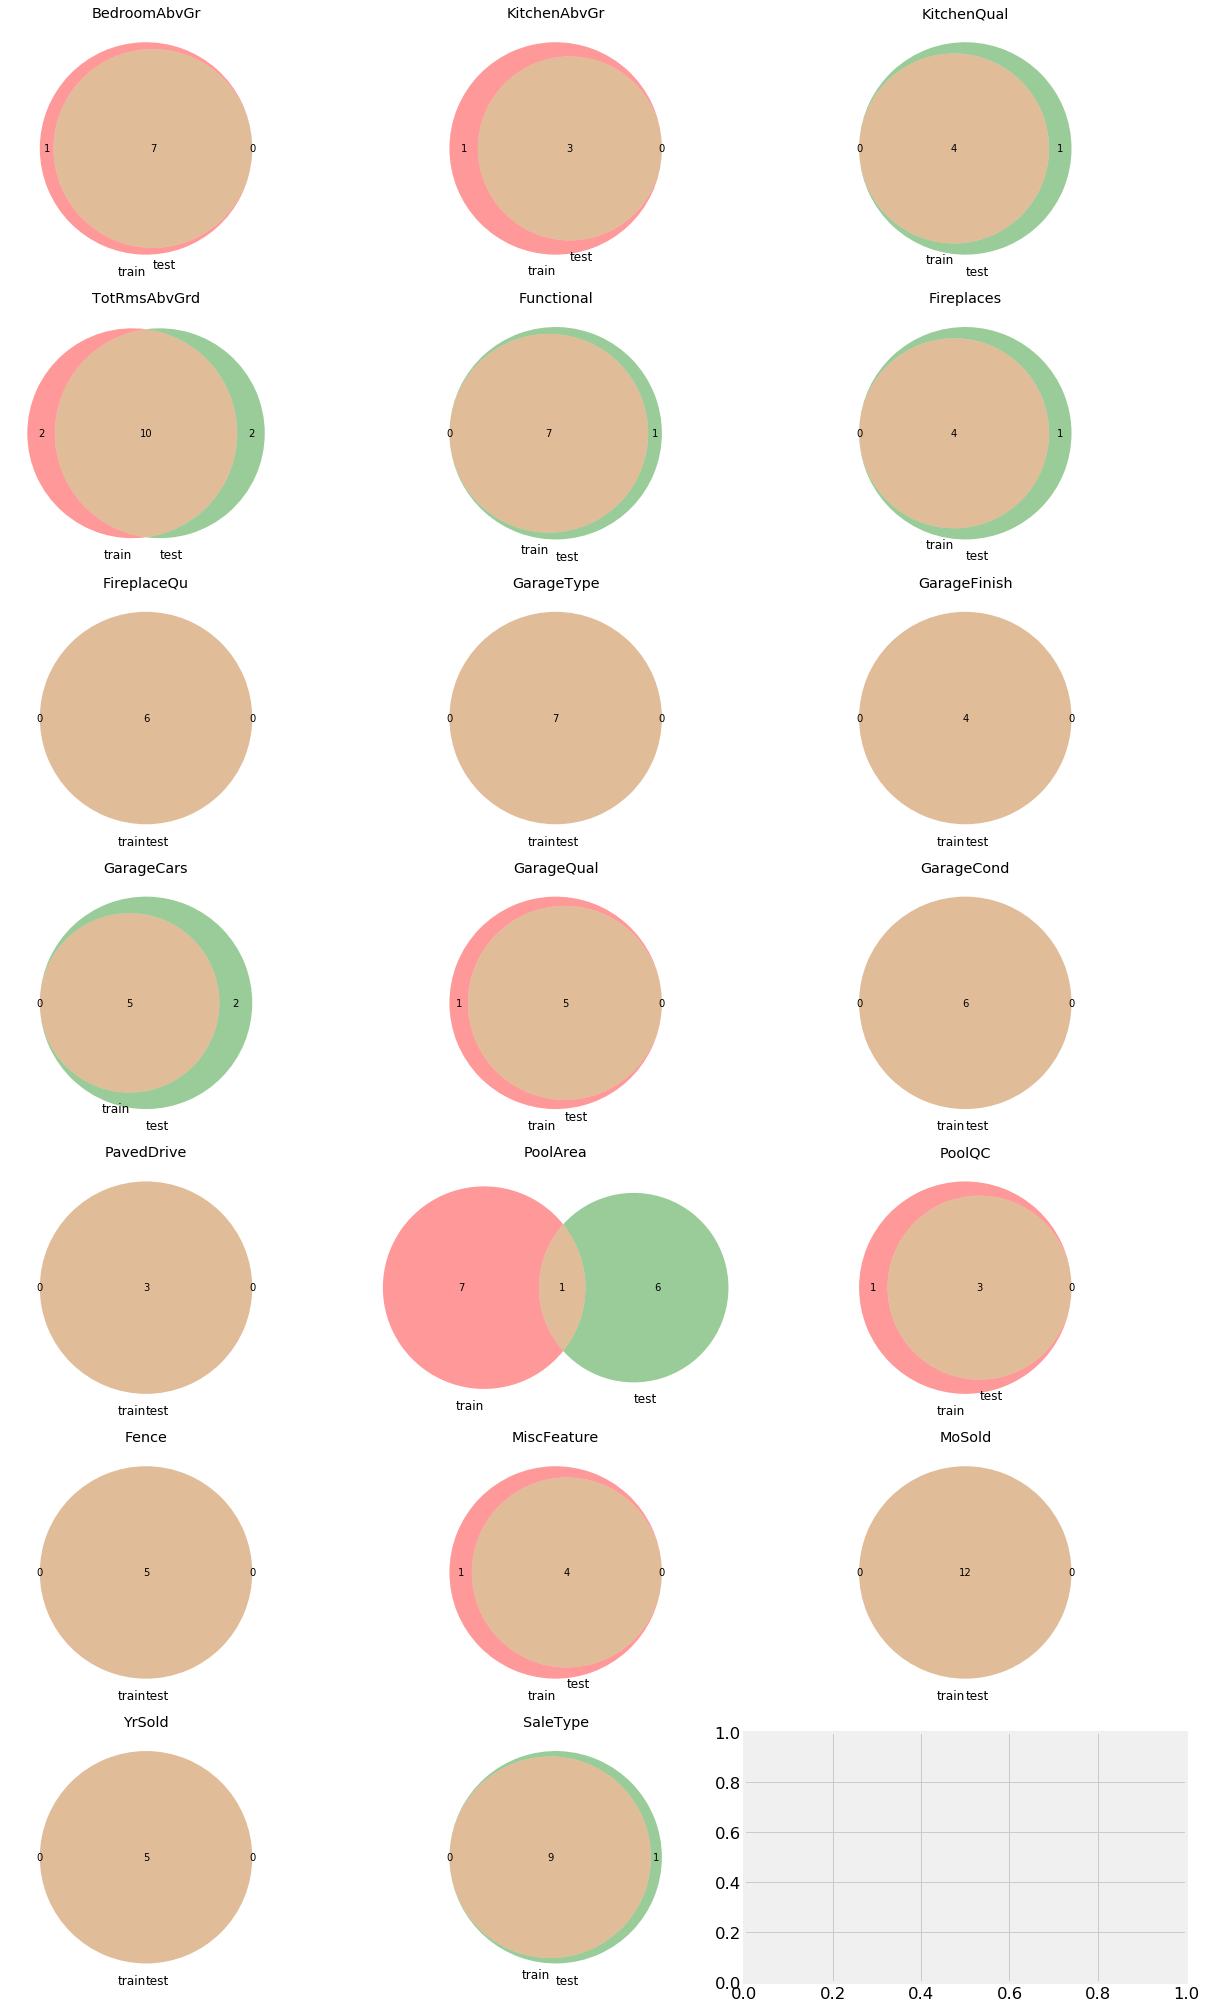

In [28]:
vc.plot_venn()

In [29]:
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = MSZoning
feature name = Street
feature name = Alley
feature name = LotShape
feature name = LandContour
feature name = Utilities
feature name = LotConfig
feature name = LandSlope
feature name = Neighborhood
feature name = Condition1
feature name = Condition2
feature name = BldgType
feature name = HouseStyle
feature name = OverallQual
feature name = OverallCond
feature name = RoofStyle
feature name = RoofMatl
feature name = Exterior1st
feature name = Exterior2nd
feature name = MasVnrType
feature name = ExterQual
feature name = ExterCond
feature name = Foundation
feature name = BsmtQual
feature name = BsmtCond
feature name = BsmtExposure
feature name = BsmtFinType1
feature name = BsmtFinType2
feature name = Heating
feature name = HeatingQC
feature name = CentralAir
feature name = Electrical
feature name = BsmtFullBath
feature name = BsmtHalfBath
feature name = FullBath
feature name = HalfBath
feature name = BedroomAbvGr
feature name = KitchenAbvGr
feature name = KitchenQual

In [30]:
chkc.style.background_gradient()

,features,overlap,train_nans,test_nans,train_nunique,test_nunique
0,MSZoning,0.833333,0,4,5,5
1,Street,1,0,0,2,2
2,Alley,0.666667,1369,1352,2,2
3,LotShape,1,0,0,4,4
4,LandContour,1,0,0,4,4
5,Utilities,0.666667,0,2,2,1
6,LotConfig,1,0,0,5,5
7,LandSlope,1,0,0,3,3
8,Neighborhood,1,0,0,25,25
9,Condition1,1,0,0,9,9


In [31]:
# remove categorical features which have different values between train and test
cat_features = [c for c in cat_features if chkc.loc[chkc["features"] == c, "overlap"].iloc[0] == 1]
print(len(cat_features))
cat_features

27


['Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleCondition']

# Fit LGB and Get Feature importance

In [32]:
# label encoding object features
train, test, cat_features = label_encoding(train, test, cat_features)

In [33]:
features = dense_features + cat_features
target in features

False

In [34]:
# fit LGB
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="lgb", task="regression", cv_method="StratifiedKFold", seed=1220)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	training's rmse: 18009.4	valid_1's rmse: 27557.9
Partial score of fold 0 is: 27557.91318897216
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1015]	training's rmse: 15439.3	valid_1's rmse: 27602.3
Partial score of fold 1 is: 27602.25714231653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	training's rmse: 21215.9	valid_1's rmse: 23575.1
Partial score of fold 2 is: 23575.068853960925
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	training's rmse: 18012	valid_1's rmse: 39334.3
Partial score of fold 3 is: 39334.26999294066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	training's rmse: 23237.3	valid_1's rmse: 22134.2
Partial score of fold 4 is: 22134.195482308325
Our oof l

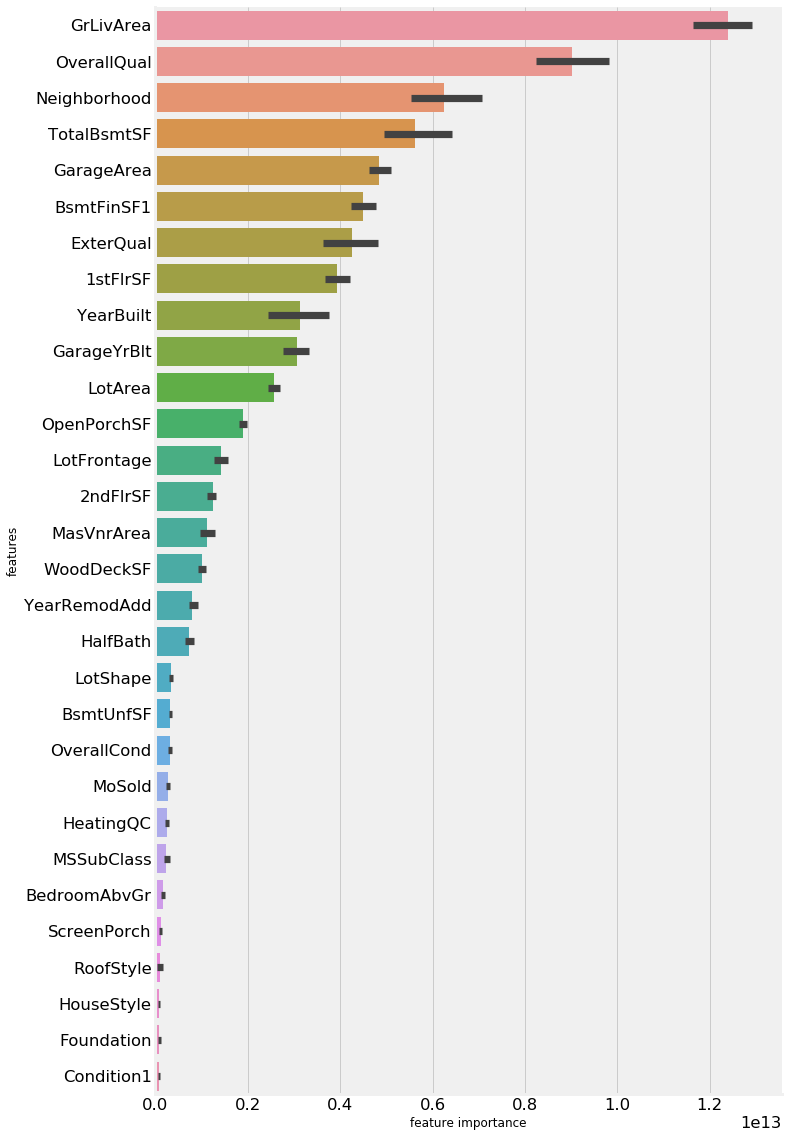

In [35]:
# plot feature importance
lgb_fi_df = lgbm.plot_feature_importance(rank_range=[1,30])

In [36]:
# fit CatB
cbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="catb", task="regression", cv_method="StratifiedKFold", seed=1220)

0:	learn: 75753.4944512	test: 75011.4710751	best: 75011.4710751 (0)	total: 59.2ms	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 22166.96451
bestIteration = 544

Shrink model to first 545 iterations.
Partial score of fold 0 is: 22166.964507592184
0:	learn: 75560.2257772	test: 76366.7172821	best: 76366.7172821 (0)	total: 6.68ms	remaining: 13.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 24577.7432
bestIteration = 1003

Shrink model to first 1004 iterations.
Partial score of fold 1 is: 24577.743197365566
0:	learn: 76809.6207118	test: 70816.8336068	best: 70816.8336068 (0)	total: 4.38ms	remaining: 8.77s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 21531.3732
bestIteration = 1056

Shrink model to first 1057 iterations.
Partial score of fold 2 is: 21531.373200772596
0:	learn: 72372.4217481	test: 90469.2229191	best: 90469.2229191 (0)	total: 4.21ms	remaining: 8.41s
Stopped by overfitting detector  (100 iteratio

In [37]:
# fit XGB
xgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="xgb", task="regression", cv_method="StratifiedKFold", seed=1220)

[0]	validation_0-rmse:176848
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[236]	validation_0-rmse:23598

Partial score of fold 0 is: 23598.01870653383
[0]	validation_0-rmse:187784
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[197]	validation_0-rmse:25451.9

Partial score of fold 1 is: 25451.932684989144
[0]	validation_0-rmse:181034
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[712]	validation_0-rmse:22172.8

Partial score of fold 2 is: 22172.76050244364
[0]	validation_0-rmse:193731
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[52]	validation_0-rmse:47523

Partial score of fold 3 is: 47522.9854545306
[0]	validation_0-rmse:175297
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[346]	validation_0-rmse:21016.6

Partial score of fold 4 is: 21016.594783250464
Our 

In [38]:
# fit linear
linm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="linear", task="regression", cv_method="StratifiedKFold", scaler="Standard", seed=1220)

Partial score of fold 0 is: 32058.781728979728
Partial score of fold 1 is: 36480.7441412286
Partial score of fold 2 is: 30548.107101576054
Partial score of fold 3 is: 60730.50973120416
Partial score of fold 4 is: 27308.98014699907
Our oof loss score is:  38844.56257364569


In [39]:
# fit NN
nnm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="nn", task="regression", cv_method="StratifiedKFold", scaler="MinMax", seed=1220)

Train on 1128 samples, validate on 332 samples
Epoch 1/80
1128/1128 [==============================] - ETA: 31s - loss: 38957596672.00 - ETA: 3s - loss: 39309862502.4000 - ETA: 0s - loss: 40247241216.000 - 5s 4ms/step - loss: 39790821405.0496 - val_loss: 36485044199.3253
Epoch 2/80
1128/1128 [==============================] - ETA: 0s - loss: 42078339072.000 - ETA: 0s - loss: 40633310412.800 - 0s 143us/step - loss: 39790305367.1489 - val_loss: 36484528991.6145
Epoch 3/80
1128/1128 [==============================] - ETA: 0s - loss: 41307156480.000 - ETA: 0s - loss: 40426396057.600 - 0s 148us/step - loss: 39789795081.0780 - val_loss: 36484041987.0843
Epoch 4/80
1128/1128 [==============================] - ETA: 0s - loss: 42934788096.000 - ETA: 0s - loss: 39841524940.800 - ETA: 0s - loss: 39903441920.000 - 0s 163us/step - loss: 39789315878.1277 - val_loss: 36483588688.1928
Epoch 5/80
1128/1128 [==============================] - ETA: 0s - loss: 42106044416.000 - ETA: 0s - loss: 38993429708.

1128/1128 [==============================] - ETA: 0s - loss: 48567468032.000 - ETA: 0s - loss: 41502605312.000 - ETA: 0s - loss: 39730142720.000 - 0s 151us/step - loss: 39786078091.8014 - val_loss: 36480636311.1325
Epoch 41/80
1128/1128 [==============================] - ETA: 0s - loss: 44418568192.000 - ETA: 0s - loss: 40769091174.400 - 0s 146us/step - loss: 39786051889.0213 - val_loss: 36480603543.1325
Epoch 42/80
1128/1128 [==============================] - ETA: 0s - loss: 36429189120.000 - ETA: 0s - loss: 38231162880.000 - 0s 145us/step - loss: 39786016971.3475 - val_loss: 36480573291.9518
Epoch 43/80
1128/1128 [==============================] - ETA: 0s - loss: 44316295168.000 - ETA: 0s - loss: 38128506880.000 - ETA: 0s - loss: 38548303360.000 - 0s 151us/step - loss: 39785988212.1986 - val_loss: 36480541930.4096
Epoch 44/80
1128/1128 [==============================] - ETA: 0s - loss: 42909483008.000 - ETA: 0s - loss: 40036062822.400 - 0s 146us/step - loss: 39785951464.3972 - val_lo

1128/1128 [==============================] - ETA: 0s - loss: 41309585408.000 - ETA: 0s - loss: 39458039808.000 - ETA: 0s - loss: 39468799122.285 - 0s 181us/step - loss: 39784850657.1348 - val_loss: 36479422340.6265
Epoch 79/80
1128/1128 [==============================] - ETA: 0s - loss: 38205890560.000 - ETA: 0s - loss: 39476320256.000 - ETA: 0s - loss: 39983424658.285 - 0s 168us/step - loss: 39784821375.0922 - val_loss: 36479388931.0843
Epoch 80/80
1128/1128 [==============================] - ETA: 0s - loss: 40247148544.000 - ETA: 0s - loss: 41671739392.000 - ETA: 0s - loss: 39436795904.000 - 0s 174us/step - loss: 39784778265.4184 - val_loss: 36479352535.9036
Partial score of fold 0 is: 190995.69479475167
Train on 1164 samples, validate on 296 samples
Epoch 1/80
1164/1164 [==============================] - ETA: 30s - loss: 40857165824.00 - ETA: 4s - loss: 39703477248.0000 - ETA: 0s - loss: 38617008128.000 - 5s 4ms/step - loss: 38566936815.2852 - val_loss: 40897332749.8378
Epoch 2/80
1

Epoch 34/80
1164/1164 [==============================] - ETA: 0s - loss: 44302934016.000 - ETA: 0s - loss: 40797406003.200 - ETA: 0s - loss: 39583944704.000 - 0s 155us/step - loss: 38562004928.6598 - val_loss: 40892380353.7297
Epoch 35/80
1164/1164 [==============================] - ETA: 0s - loss: 35984064512.000 - ETA: 0s - loss: 37986816819.200 - ETA: 0s - loss: 38544211968.000 - 0s 167us/step - loss: 38561965904.0550 - val_loss: 40892342936.2162
Epoch 36/80
1164/1164 [==============================] - ETA: 0s - loss: 41109692416.000 - ETA: 0s - loss: 38488975360.000 - ETA: 0s - loss: 39043710976.000 - 0s 157us/step - loss: 38561941032.4674 - val_loss: 40892305518.7027
Epoch 37/80
1164/1164 [==============================] - ETA: 0s - loss: 35957940224.000 - ETA: 0s - loss: 39508170342.400 - ETA: 0s - loss: 39175142912.000 - 0s 159us/step - loss: 38561902507.5464 - val_loss: 40892270979.4595
Epoch 38/80
1164/1164 [==============================] - ETA: 0s - loss: 36852994048.000 - E

1164/1164 [==============================] - ETA: 0s - loss: 34440683520.000 - ETA: 0s - loss: 38181497856.000 - ETA: 0s - loss: 37922105051.428 - 0s 171us/step - loss: 38560739257.6220 - val_loss: 40891032437.6216
Epoch 71/80
1164/1164 [==============================] - ETA: 0s - loss: 33180968960.000 - ETA: 0s - loss: 39149264384.000 - ETA: 0s - loss: 38539584365.714 - 0s 166us/step - loss: 38560701851.7113 - val_loss: 40890994355.8919
Epoch 72/80
1164/1164 [==============================] - ETA: 0s - loss: 33134436352.000 - ETA: 0s - loss: 37031782400.000 - ETA: 0s - loss: 38712921526.857 - 0s 168us/step - loss: 38560662369.6495 - val_loss: 40890956938.3784
Epoch 73/80
1164/1164 [==============================] - ETA: 0s - loss: 37673779200.000 - ETA: 0s - loss: 38726024192.000 - ETA: 0s - loss: 37464248905.142 - 0s 179us/step - loss: 38560640059.8213 - val_loss: 40890917749.6216
Epoch 74/80
1164/1164 [==============================] - ETA: 0s - loss: 44419977216.000 - ETA: 0s - los

1162/1162 [==============================] - ETA: 0s - loss: 40527900672.000 - ETA: 0s - loss: 38437389107.200 - ETA: 0s - loss: 39062246741.333 - 0s 154us/step - loss: 39200314394.4372 - val_loss: 38391715193.9866
Epoch 26/80
1162/1162 [==============================] - ETA: 0s - loss: 39127318528.000 - ETA: 0s - loss: 40765911040.000 - ETA: 0s - loss: 39074436437.333 - 0s 152us/step - loss: 39200279610.1618 - val_loss: 38391678907.2752
Epoch 27/80
1162/1162 [==============================] - ETA: 0s - loss: 45192433664.000 - ETA: 0s - loss: 40709499289.600 - ETA: 0s - loss: 39285896078.222 - 0s 153us/step - loss: 39200243793.0740 - val_loss: 38391644379.9195
Epoch 28/80
1162/1162 [==============================] - ETA: 0s - loss: 46225448960.000 - ETA: 0s - loss: 39918977024.000 - ETA: 0s - loss: 38840163328.000 - 0s 156us/step - loss: 39200204613.1773 - val_loss: 38391606938.6309
Epoch 29/80
1162/1162 [==============================] - ETA: 0s - loss: 39683297280.000 - ETA: 0s - los

1162/1162 [==============================] - ETA: 0s - loss: 41851305984.000 - ETA: 0s - loss: 37483911168.000 - ETA: 0s - loss: 39393674386.285 - 0s 168us/step - loss: 39199120258.8640 - val_loss: 38390476442.6309
Epoch 62/80
1162/1162 [==============================] - ETA: 0s - loss: 36908187648.000 - ETA: 0s - loss: 37907965952.000 - ETA: 0s - loss: 38537762816.000 - 0s 166us/step - loss: 39199086588.4750 - val_loss: 38390443674.6309
Epoch 63/80
1162/1162 [==============================] - ETA: 0s - loss: 32166055936.000 - ETA: 0s - loss: 39368654848.000 - ETA: 0s - loss: 39617839689.142 - 0s 172us/step - loss: 39199048652.8881 - val_loss: 38390407387.9195
Epoch 64/80
1162/1162 [==============================] - ETA: 0s - loss: 38630932480.000 - ETA: 0s - loss: 41069188096.000 - ETA: 0s - loss: 39219329316.571 - 0s 170us/step - loss: 39199012515.0293 - val_loss: 38390371705.9866
Epoch 65/80
1162/1162 [==============================] - ETA: 0s - loss: 40948154368.000 - ETA: 0s - los

Epoch 17/80
1191/1191 [==============================] - ETA: 0s - loss: 38047899648.000 - ETA: 0s - loss: 37632409600.000 - ETA: 0s - loss: 38231462343.111 - 0s 146us/step - loss: 37960169133.2460 - val_loss: 43795024108.0149
Epoch 18/80
1191/1191 [==============================] - ETA: 0s - loss: 33140322304.000 - ETA: 0s - loss: 36108821708.800 - ETA: 0s - loss: 37603107043.555 - 0s 152us/step - loss: 37960126694.4215 - val_loss: 43794975153.9628
Epoch 19/80
1191/1191 [==============================] - ETA: 0s - loss: 37193482240.000 - ETA: 0s - loss: 39561666560.000 - ETA: 0s - loss: 39769980928.000 - 0s 157us/step - loss: 37960081493.9782 - val_loss: 43794930493.8587
Epoch 20/80
1191/1191 [==============================] - ETA: 0s - loss: 35242639360.000 - ETA: 0s - loss: 37805202636.800 - ETA: 0s - loss: 37670123292.444 - 0s 151us/step - loss: 37960043704.8531 - val_loss: 43794889335.9108
Epoch 21/80
1191/1191 [==============================] - ETA: 0s - loss: 33240879104.000 - E

1191/1191 [==============================] - ETA: 0s - loss: 37893865472.000 - ETA: 0s - loss: 38966224896.000 - ETA: 0s - loss: 38586033298.285 - 0s 160us/step - loss: 37958913296.5508 - val_loss: 43793662347.8959
Epoch 54/80
1191/1191 [==============================] - ETA: 0s - loss: 36442284032.000 - ETA: 0s - loss: 38435384320.000 - ETA: 0s - loss: 37944320292.571 - 0s 161us/step - loss: 37958872252.2922 - val_loss: 43793625483.8959
Epoch 55/80
1191/1191 [==============================] - ETA: 0s - loss: 32362393600.000 - ETA: 0s - loss: 36190119936.000 - ETA: 0s - loss: 37742089947.428 - 0s 164us/step - loss: 37958835123.4794 - val_loss: 43793588619.8959
Epoch 56/80
1191/1191 [==============================] - ETA: 0s - loss: 37398413312.000 - ETA: 0s - loss: 37370319872.000 - ETA: 0s - loss: 37781688905.142 - 0s 162us/step - loss: 37958798909.4744 - val_loss: 43793550004.8178
Epoch 57/80
1191/1191 [==============================] - ETA: 0s - loss: 42904342528.000 - ETA: 0s - los

Epoch 9/80
1195/1195 [==============================] - ETA: 0s - loss: 35258793984.000 - ETA: 0s - loss: 38465197670.400 - ETA: 0s - loss: 39329379214.222 - 0s 142us/step - loss: 39697406375.3105 - val_loss: 36050860936.2113
Epoch 10/80
1195/1195 [==============================] - ETA: 0s - loss: 44215525376.000 - ETA: 0s - loss: 41428201472.000 - ETA: 0s - loss: 39844408206.222 - 0s 140us/step - loss: 39697235837.7506 - val_loss: 36050714593.0868
Epoch 11/80
1195/1195 [==============================] - ETA: 0s - loss: 37483974656.000 - ETA: 0s - loss: 38868198195.200 - ETA: 0s - loss: 39830716416.000 - 0s 142us/step - loss: 39697103357.0008 - val_loss: 36050596643.7434
Epoch 12/80
1195/1195 [==============================] - ETA: 0s - loss: 39043952640.000 - ETA: 0s - loss: 39047593984.000 - ETA: 0s - loss: 39126793784.888 - 0s 138us/step - loss: 39696998694.7749 - val_loss: 36050501083.2906
Epoch 13/80
1195/1195 [==============================] - ETA: 0s - loss: 34487943168.000 - ET

1195/1195 [==============================] - ETA: 0s - loss: 40833449984.000 - ETA: 0s - loss: 40086322380.800 - ETA: 0s - loss: 39575388615.111 - 0s 150us/step - loss: 39695564638.9021 - val_loss: 36049094694.6415
Epoch 46/80
1195/1195 [==============================] - ETA: 0s - loss: 35281911808.000 - ETA: 0s - loss: 37816546918.400 - ETA: 0s - loss: 39861380437.333 - 0s 152us/step - loss: 39695531778.3565 - val_loss: 36049061006.9736
Epoch 47/80
1195/1195 [==============================] - ETA: 0s - loss: 43005853696.000 - ETA: 0s - loss: 42753369702.400 - ETA: 0s - loss: 40038619818.666 - 0s 151us/step - loss: 39695497541.6234 - val_loss: 36049022373.1925
Epoch 48/80
1195/1195 [==============================] - ETA: 0s - loss: 35765084160.000 - ETA: 0s - loss: 38723425075.200 - ETA: 0s - loss: 38927073280.000 - 0s 154us/step - loss: 39695454132.5925 - val_loss: 36048988824.6340
Epoch 49/80
1195/1195 [==============================] - ETA: 0s - loss: 37587165184.000 - ETA: 0s - los

Partial score of fold 4 is: 189862.60357607313
Our oof loss score is:  197567.08625669187
